# Personality prediction

In [2]:
import numpy as np
np.random.seed(113) #set seed before any keras import
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from keras.preprocessing import sequence
from collections import Counter

Using TensorFlow backend.


## Dataset

First we load the dataset. I built a single csv file that is easy to load and handle using pandas. The original label tagset of TwiSty consists of 16 different labels, however I am going to transform it into a binary classification problem: I will only predict the I(introvert) and E(extrovert) personality traits.

The dataset is huge and it require a lot of RAM: for this reason I decided to trim the maximum number of characters of text per author to 1000. This means that the toy will be a toy model.

In [99]:
seed=0
corpus = pd.read_csv('twistytest.csv', 
                     index_col=0, 
                     header=1, 
                     names=['user_id', 'lang', 'text', 'mbti'])

#here we limit the corpus size. The SVM with all the text can learn somethign
corpus.text = corpus.text.apply(lambda x: x) 
corpus.mbti = corpus.mbti.apply(lambda x: x[0])

#corpus = tmp.sample(frac=1, random_state=seed)
e = corpus[corpus.mbti.apply(lambda x: x == 'E')]
i = corpus[corpus.mbti.apply(lambda x: x == 'I')].sample(226)
corpus = pd.concat([e,i]).sample(frac=1, random_state=seed)
print(corpus.shape)

## set max length of doc per author
sentences = corpus.text#.apply(lambda x: x[:100000])
## trim labels: convert problem to binary classification I vs E
labels = corpus.mbti

## make sure we have a label for every data instance
assert(len(sentences)==len(labels))
data={}
np.random.seed(113) #seed
data['target']= np.random.permutation(labels)
np.random.seed(113) # use same seed!
data['data'] = np.random.permutation(sentences)

(452, 4)


In [100]:
# preview the dataset
print(corpus.shape)
corpus.head()

(452, 4)


,user_id,lang,text,mbti
544,113022898,de,['@Stoffnuss Ich glaube Emil wird nicht lange ...,E
280,108731189,it,"['http://t.co/pYyYAMCJAc', ""AGE SEMPRE PIU' PR...",E
848,313458775,de,['@Jaqi_Metalbraut wh00t? Ich dacht Endivie wä...,I
324,531664179,it,"[""#Ironman3 in one of the most glorious movies...",I
483,1166332766,it,"['La tecnologia mi odia.', ""Io stamattina: ogg...",I


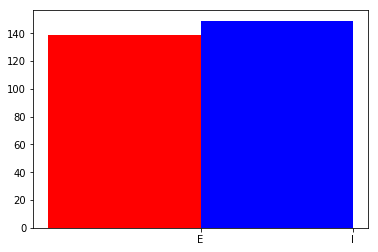

In [101]:
# plot the distribution of labels

import matplotlib.pyplot as plt

l, v = zip(*Counter(y_train).items())
indexes = np.arange(len(l))
width = 1
plt.bar(indexes, v, width, color=['r', 'b'])
plt.xticks(indexes + width * 0.5, l)
plt.show()

In [102]:
#split the data into train, dev, test

X_rest, X_test, y_rest, y_test = train_test_split(data['data'], data['target'], test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_rest, y_rest, test_size=0.2)
del X_rest, y_rest
print("#train instances: {} #dev: {} #test: {}".format(len(X_train),len(X_dev),len(X_test)))

#train instances: 288 #dev: 73 #test: 91


In [103]:
# compute random baseline per class
Counter(y_test)['I']/sum(Counter(y_test).values())

0.5274725274725275

### Test and dev set label distribution

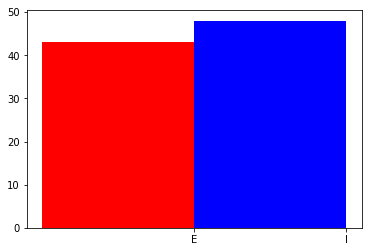

In [104]:
# test
l, v = zip(*Counter(y_test).items())
indexes = np.arange(len(l))
width = 1
plt.bar(indexes, v, width, color=['r', 'b'])
plt.xticks(indexes + width * 0.5, l)
plt.show()

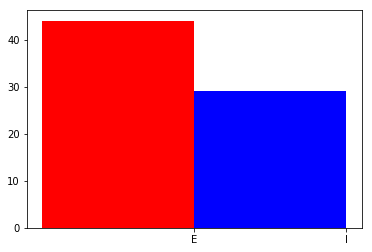

In [105]:
# dev
l, v = zip(*Counter(y_dev).items())
indexes = np.arange(len(l))
width = 1
plt.bar(indexes, v, width, color=['r', 'b'])
plt.xticks(indexes + width * 0.5, l)
plt.show()

## Baseline

For the baseline we use an SVM with a sparse feature representation.

We use both character- and word-ngrams.

In [96]:
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pipeline = Pipeline([('features', FeatureUnion([('wngram', TfidfVectorizer(ngram_range=(1,2))),
                                                ('cngram', TfidfVectorizer(analyzer='char'))])),
                     ('cls', DummyClassifier())])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_dev)
accuracy_score(predictions, y_dev)

print(classification_report(predictions, y_dev))

testpredictions = pipeline.predict(X_test)
print(accuracy_score(testpredictions, y_test))

print(classification_report(testpredictions, y_test))

             precision    recall  f1-score   support

          E       0.45      0.65      0.53        31
          I       0.62      0.43      0.51        42

avg / total       0.55      0.52      0.52        73

0.483516483516
             precision    recall  f1-score   support

          E       0.47      0.45      0.46        44
          I       0.50      0.51      0.51        47

avg / total       0.48      0.48      0.48        91



In [106]:
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pipeline = Pipeline([('features', FeatureUnion([('wngram', TfidfVectorizer(ngram_range=(1,2))),
                                                ('cngram', TfidfVectorizer(analyzer='char'))])),
                     ('cls', LinearSVC())])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_dev)
accuracy_score(predictions, y_dev)

print(classification_report(predictions, y_dev))

             precision    recall  f1-score   support

          E       0.64      0.68      0.66        41
          I       0.55      0.50      0.52        32

avg / total       0.60      0.60      0.60        73



## Results

The SVM works quite well already: we outperform the random baseline by a signficant margin.

In [107]:
testpred = pipeline.predict(X_test)
print(accuracy_score(testpred, y_test))
print(classification_report(testpred, y_test))

0.692307692308
             precision    recall  f1-score   support

          E       0.67      0.67      0.67        43
          I       0.71      0.71      0.71        48

avg / total       0.69      0.69      0.69        91



## Neural network

First we have to encode the labels in the one-hot format. Since this is a binary classification format, we don't convert them to a categorical format.

In [30]:
from keras.utils import np_utils
y2i = defaultdict(lambda: len(y2i))
y_train_num = [y2i[mbti] for mbti in y_train]
y_dev_num = [y2i[mbti] for mbti in y_dev]
y_test_num = [y2i[mbti] for mbti in y_test]
num_classes = len(np.unique(y_train_num))
print(num_classes)

2


## Text representation

For the baseline we used a one-hot encoding. For our neural model we are going to represent the text using a dense representation. We will be building it from characters.

In [31]:
from collections import defaultdict

# convert words to indices, taking care of UNKs
def get_characters(sentence, c2i):
    out = []
    for word in sentence.split(" "):
        chars = []
        for c in word:
            chars.append(c2i[c])
        out.append(chars)
    return out

c2i = defaultdict(lambda: len(c2i))

PAD = c2i["<pad>"] # index 0 is padding
UNK = c2i["<unk>"] # index 1 is for UNK
X_train_num = [get_characters(sentence, c2i) for sentence in X_train]
c2i = defaultdict(lambda: UNK, c2i) # freeze - cute trick!
X_dev_num = [get_characters(sentence, c2i) for sentence in X_dev]
X_test_num = [get_characters(sentence, c2i) for sentence in X_test]

max_sentence_length=max([len(s.split(" ")) for s in X_train] 
                        + [len(s.split(" ")) for s in X_dev] 
                        + [len(s.split(" ")) for s in X_test] )
max_word_length = max([len(word)  for sentence in X_train_num for word in sentence])

In [32]:
### we need both max sent and word length
print(max_sentence_length)
print(max_word_length)
print(X_train[0:2])
print(X_train_num[0:2]) # example how the first two sentences are encoded

893
139
[ '[\'Dio, se esisti, aiutami!\', \'The Walking Dead Game Season 2 Episode 3 Trailer: http://t.co/VC66OtRYjf \\nOMMIODDIO!\', \'La mia cara compagna di banco e le sue perle #invalsi2014 http://t.co/RPY9nn2ZO1\', \'Chiedo perdono se non sono molto attiva ultimamente\', \'Comunque non fidatevi della gente, è simpatica solo perché siete in qualche modo utili\', \'#iononvotoM5S anche perché io non posso proprio votare, ehehhe!\', \'"@JFloydZeppelin: @bohemianfloyd http://t.co/gfxe3OQAQJ" you\\\'re a very very nice person :\\\')\', \'Ma perché i Noctiluca sono bioluminescenti e io no?\\nMi sento profondamente offesa\', \'Questa settimana ho:\\n-Versione\\n-Compito di inglese, scienze, disegno e fisica\\n-Interrogazione di poesia e compito http://t.co/dwYafO4h96\', \'Domani ho la versione, è stato un piacere conoscervi :D\', \'Perché perdere tempo con le persone che vi stanno antipatiche, quando potete semplicemente ignorarle?\', \'@hatewillkillus nera ;)\', \'Oggi è una giornata da 

In [33]:
def pad_words(tensor_words, max_word_len, pad_symbol_id, max_sent_len=None):
    """
    pad character list all to same word length
    """
    padded = []
    for words in tensor_words:
        if max_sent_len: #pad all to same sentence length (insert empty word list)
            words = [[[0]]*(max_sent_len-len(words))+ words][0] #prepending empty words
        padded.append(sequence.pad_sequences(words, maxlen=max_word_len, value=pad_symbol_id))
    return np.array(padded)

In [34]:
X_train_pad_char = pad_words(X_train_num, max_word_length, 0, max_sent_len=max_sentence_length)
X_dev_pad_char = pad_words(X_dev_num, max_word_length, 0, max_sent_len=max_sentence_length)
X_test_pad_char = pad_words(X_test_num, max_word_length, 0, max_sent_len=max_sentence_length)

In [35]:
X_train_pad_char.shape

(57, 893, 139)

In [108]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, GRU, TimeDistributed, Embedding, Bidirectional
import keras

### Composing words only out of characters



Instead of using a separate word embedding matrix, compose words through characters (see https://aclweb.org/anthology/W/W16/W16-4303.pdf)

In [60]:
batch_size=8
max_chars = len(c2i)
c_dim=50
c_h_dim=32
w_h_dim=32
char_vocab_size = len(c2i)

## lower-level character LSTM
input_chars = Input(shape=(max_sentence_length, max_word_length), name='main_input')

embedded_chars = TimeDistributed(Embedding(char_vocab_size, c_dim,
                                         input_length=max_word_length), name='char_embedding')(input_chars)
char_lstm = TimeDistributed(Bidirectional(GRU(c_h_dim)), name='GRU_on_char')(embedded_chars)

word_lstm_from_char = Bidirectional(GRU(w_h_dim), name='GRU_on_words')(char_lstm)

# And add a prediction node on top
predictions = Dense(1, activation='relu', name='output_layer')(word_lstm_from_char)


In [61]:
model = Model(inputs=input_chars, outputs=predictions)


model.compile(loss='binary_crossentropy', optimizer='adam',
                      metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 893, 139)          0         
_________________________________________________________________
char_embedding (TimeDistribu (None, 893, 139, 50)      32900     
_________________________________________________________________
GRU_on_char (TimeDistributed (None, 893, 64)           15936     
_________________________________________________________________
GRU_on_words (Bidirectional) (None, 64)                18624     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 67,525
Trainable params: 67,525
Non-trainable params: 0
_________________________________________________________________


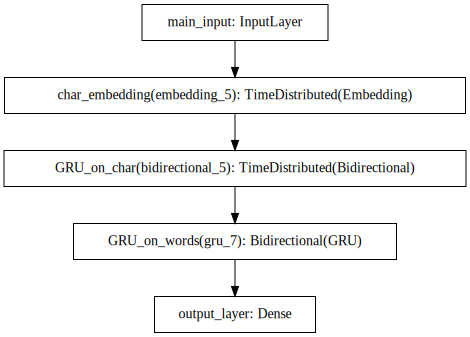

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [48]:
model.fit(X_train_pad_char, y_train_num, epochs=10, batch_size=8)

Epoch 1/10
57/57 [==============================] - 98s - loss: 8.7660 - acc: 0.4561    
Epoch 2/10
57/57 [==============================] - 98s - loss: 8.7660 - acc: 0.4561    
Epoch 3/10
57/57 [==============================] - 98s - loss: 8.7660 - acc: 0.4561    
Epoch 4/10
57/57 [==============================] - 98s - loss: 8.7660 - acc: 0.4561    
Epoch 5/10
57/57 [==============================] - 98s - loss: 8.7660 - acc: 0.4561    
Epoch 6/10
57/57 [==============================] - 99s - loss: 8.7660 - acc: 0.4561    
Epoch 7/10
57/57 [==============================] - 99s - loss: 8.7660 - acc: 0.4561    
Epoch 8/10
57/57 [==============================] - 99s - loss: 8.7660 - acc: 0.4561    
Epoch 9/10
57/57 [==============================] - 99s - loss: 8.7660 - acc: 0.4561    
Epoch 10/10
57/57 [==============================] - 99s - loss: 8.7660 - acc: 0.4561    


In [49]:
loss, accuracy = model.evaluate(X_dev_pad_char, y_dev_num)

15/15 [==============================] - 9s


In [42]:
print(accuracy)

0.40000000596


In [50]:
loss, accuracy = model.evaluate(X_test_pad_char, y_test_num)

18/18 [==============================] - 11s


In [51]:
print(accuracy)

0.666666686535


## Conclusions

The model did not learn anything at all: the performance reflects the label distribution in the test set. When trained with enough data, the SVM can learn and solve to some extent the problem. The neural model needs a lot more data.